In [1]:
%pylab inline
import nengo
from nengo.dists import Uniform
import numpy as np
import matplotlib.pyplot as plt
from nengolib import DoubleExp

Populating the interactive namespace from numpy and matplotlib


### Simple harmonic oscillator in LIF neurons with default firing rates:

In [2]:
model = nengo.Network()
with model:
    stim = nengo.Node(lambda t: [1,0] if t<0.1 else [0,0])
    osc = nengo.Ensemble(1000, dimensions= 2)
    nengo.Connection(stim, osc)
    nengo.Connection(osc, osc, transform= [[1, 1], [-1, 1]], synapse=0.1)
    osc_p = nengo.Probe(osc, synapse=0.1)

sim = nengo.Simulator(model)
sim.run(5)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

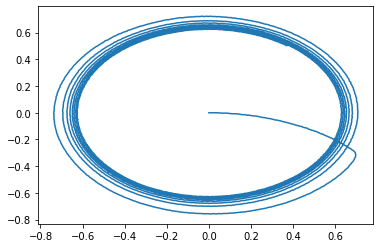

In [3]:
figure()
plot(sim.data[osc_p][:,0],sim.data[osc_p][:,1])

It works

### Simple harmonic oscillator in LIF neurons with low firing rates:

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

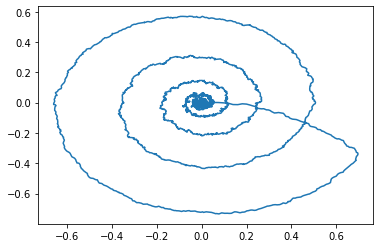

In [4]:
model = nengo.Network()
with model:
    stim = nengo.Node(lambda t: [1,0] if t<0.1 else [0,0])
    osc = nengo.Ensemble(1000, dimensions= 2, max_rates = nengo.dists.Uniform(30,50))
    nengo.Connection(stim, osc)
    nengo.Connection(osc, osc, transform= [[1, 1], [-1, 1]], synapse=0.1)
    osc_p = nengo.Probe(osc, synapse=0.1)

sim = nengo.Simulator(model)
sim.run(5)

figure()
plot(sim.data[osc_p][:,0],sim.data[osc_p][:,1])

It doesn't work :(

### Attractive nonlinear oscillator in LIF neurons with default firing rates:

A SHO:
\begin{align} \frac{d}{dt}
\begin{bmatrix}
x \\ y
\end{bmatrix} &= \begin{bmatrix}
0 & -\omega \\ \omega & 0
\end{bmatrix} \begin{bmatrix}
x \\ y
\end{bmatrix}
\end{align}
So
\begin{align}
\dot{r} &= \frac{x\dot{x} + y\dot{y}}{r} = 0  \\
\dot{\theta} &= \frac{-y\dot{x} + x\dot{y}}{r^2} = \omega
\end{align}
Note that any radius is a fixed point and none are stable.

We could have nonlinear oscillator dynamics though:
\begin{align}
\dot{r} &= f(r)  \\
\dot{\theta} &= \omega
\end{align}
Where $f(r)$ is such that $f(1)=0$ so $r=1$ is a fixed point. Can it stable or attracting? 

The Jacobian matrix:
\begin{align} J = \begin{bmatrix}
\frac{df}{dr} & 0 \\ 0 & 0
\end{bmatrix}
\end{align}
Its eignvalues are
\begin{align}
\det{(J(r=1) - \lambda I)} =\begin{vmatrix}
\frac{df}{dr}|_{r=1} - \lambda & 0 \\ 0 & - \lambda
\end{vmatrix} = - (\frac{df}{dr}|_{r=1} - \lambda) \lambda = 0 \\
\lambda = 0, \frac{df}{dr}|_{r=1}
\end{align}
We know
* "if all eigenvalues are negative real numbers or complex numbers with negative real parts then the point is a stable attracting fixed point, and the nearby points converge to it at an exponential rate"
We want $f$ such that
\begin{align}
f(1) &= 0 \\
\text{Re} \left ( \left . \frac{df}{dr} \right |_{r=1} \right ) &< 0 \\
\end{align}
Examples:
\begin{align}
f(r) = 1-r \\
f(r)  = 1-r^2 \\
f(r)  = (1-r^2)/r^2
\end{align}

The dynamics as $(x,y)$
\begin{align} \frac{d}{dt}
\begin{bmatrix}
x \\ y
\end{bmatrix} &= \begin{bmatrix}
\frac{1}{r^2}( rf(r)x - \omega y) \\
\frac{1}{r^2}( rf(r)y - \omega x)
\end{bmatrix} 
\end{align}


We can also look at different dynamics with these plots:

<Figure size 432x288 with 0 Axes>

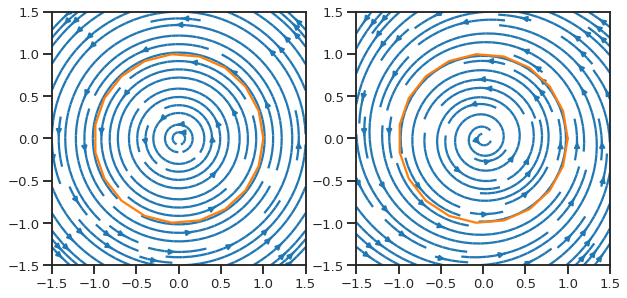

In [5]:
import seaborn as sns
import scipy.linalg


def f1(Y, t):
    y1, y2 = Y
    freq = 2*np.pi
    return [- freq*y2,  freq*y1]

def f2(Y, t):
    y1, y2 = Y
    freq = 2*np.pi
    r = np.maximum(np.sqrt(y1**2 + y2**2), 1e-8)
    return [y1*(1-r) - y2*freq, y2*(1-r) + y1*freq]



y1 = np.linspace(-1.5, 1.5, 10)
y2 = np.linspace(-1.5, 1.5, 10)
Y1, Y2 = np.meshgrid(y1, y2)

t = 0

u1, v1 = np.zeros(Y1.shape), np.zeros(Y2.shape)
u2, v2 = np.zeros(Y1.shape), np.zeros(Y2.shape)

NI, NJ = Y1.shape
for i in range(NI):
    for j in range(NJ):
        x = Y1[i, j]
        y = Y2[i, j]
        yprime = f1([x, y], t)
        u1[i,j] = yprime[0]
        v1[i,j] = yprime[1]
        yprime = f2([x, y], t)
        u2[i,j] = yprime[0]
        v2[i,j] = yprime[1]
        

sns.set_style("ticks")
sns.despine()
sns.set_context("talk", font_scale=0.8)

figure(figsize=(10,5))
ax=subplot(1,2,1)
#contourf(Y1,Y2,np.sqrt(u1**2 + v1**2))
streamplot(Y1, Y2, u1, v1)
plot(cos(2*np.pi*np.linspace(0,1,20)),sin(2*np.pi*np.linspace(0,1,20)))
ax.set_aspect('equal')

ax=subplot(1,2,2)
#contourf(Y1,Y2,np.sqrt(u2**2+v2**2))
streamplot(Y1, Y2, u2, v2)
plot(cos(2*np.pi*np.linspace(0,1,20)),sin(2*np.pi*np.linspace(0,1,20)))
ax.set_aspect('equal')

^ comparing SHO to nonlinear one
Here just the direction of flow was shown. Lets consider magnitude too

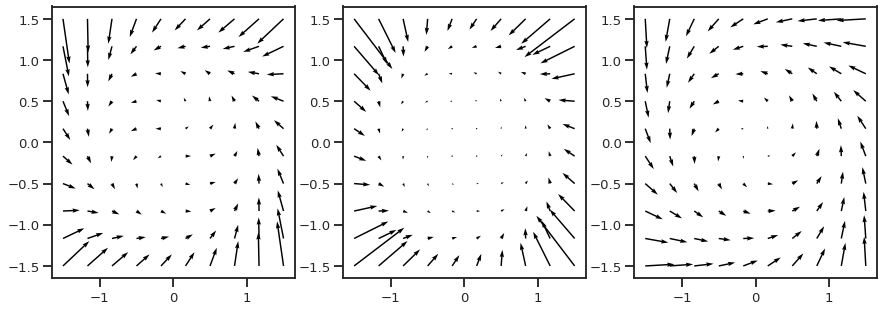

In [6]:
def f2(Y, t):
    y1, y2 = Y
    freq = 1
    r = np.maximum(np.sqrt(y1**2 + y2**2), 1e-8)
    return [y1*(1-r**2)/r - y2*freq, y2*r*(1-r**2)/r + y1*freq]

u1, v1 = np.zeros(Y1.shape), np.zeros(Y2.shape)
u2, v2 = np.zeros(Y1.shape), np.zeros(Y2.shape)
for i in range(NI):
    for j in range(NJ):
        x = Y1[i, j]
        y = Y2[i, j]
        yprime = f1([x, y], t)
        u1[i,j] = yprime[0]
        v1[i,j] = yprime[1]
        yprime = f2([x, y], t)
        u2[i,j] = yprime[0]
        v2[i,j] = yprime[1]

figure(figsize=(20,5))
ax=subplot(1,4,1)
quiver(Y1, Y2, u2, v2)


def f2(Y, t):
    y1, y2 = Y
    freq = 1
    r = np.maximum(np.sqrt(y1**2 + y2**2), 1e-8)
    return [y1*r*(1-r**2) - y2*freq, y2*r*(1-r**2) + y1*freq]

u1, v1 = np.zeros(Y1.shape), np.zeros(Y2.shape)
u2, v2 = np.zeros(Y1.shape), np.zeros(Y2.shape)
for i in range(NI):
    for j in range(NJ):
        x = Y1[i, j]
        y = Y2[i, j]
        yprime = f1([x, y], t)
        u1[i,j] = yprime[0]
        v1[i,j] = yprime[1]
        yprime = f2([x, y], t)
        u2[i,j] = yprime[0]
        v2[i,j] = yprime[1]

ax=subplot(1,4,2)
quiver(Y1, Y2, u2, v2)



def f2(Y, t):
    y1, y2 = Y
    freq = 1
    r = np.maximum(np.sqrt(y1**2 + y2**2), 1e-8)
    return [y1*(1-r) - y2*freq, y2*(1-r) + y1*freq]

u1, v1 = np.zeros(Y1.shape), np.zeros(Y2.shape)
u2, v2 = np.zeros(Y1.shape), np.zeros(Y2.shape)
for i in range(NI):
    for j in range(NJ):
        x = Y1[i, j]
        y = Y2[i, j]
        yprime = f1([x, y], t)
        u1[i,j] = yprime[0]
        v1[i,j] = yprime[1]
        yprime = f2([x, y], t)
        u2[i,j] = yprime[0]
        v2[i,j] = yprime[1]

ax=subplot(1,4,3)
quiver(Y1, Y2, u2, v2)

In [187]:
def goNormal(
    n_neurons,
    max_rates,
    intercepts,
    tauRise=1e-3,
    tauFall=1e-1,
    tKick=0.1,
    tSim=20,
    seed=0,
    w=2*np.pi,
    tTrans=1,
    neuron_type=nengo.LIF(),
    ):

    syn = DoubleExp(tauRise, tauFall)

    def feedback(x):
        r = np.maximum(np.sqrt(x[0]**2 + x[1]**2), 1e-9)
        dx0 = x[0]*(1-r**2)/r - x[1]*w 
        dx1 = x[1]*(1-r**2)/r + x[0]*w 
        return [tauFall*dx0 + x[0],  tauFall*dx1 + x[1]]

    model = nengo.Network()
    with model:
        osc = nengo.Ensemble(n_neurons, dimensions=2, neuron_type=neuron_type, max_rates=max_rates, intercepts=intercepts)
        nengo.Connection(osc, osc, function=feedback, synapse=syn)
        osc_p = nengo.Probe(osc, synapse=syn)
        spikes_p = nengo.Probe(osc.neurons, synapse=syn)

    sim = nengo.Simulator(model)
    sim.run(tSim)
    A = sim.data[spikes_p]
    A_settled = A[int(tTrans/0.001):]
    gain = sim.data[osc].gain
    bias = sim.data[osc].bias

    fig, ax = plt.subplots(figsize=((8,8)))
    ax.plot(sim.data[osc_p][:,0],sim.data[osc_p][:,1])
    ax.set(xlim=((-1,1)), ylim=((-1,1)), xticks=((-1,1)), yticks=((-1,1)))

    fig, ax = plt.subplots(figsize=((8,8)))
    ax.plot(sim.trange(), np.sin(w*sim.trange()), color='k', linewidth=0.5)
    ax.plot(sim.trange(), sim.data[osc_p])
    ax.set(xlabel='time', ylabel='state', ylim=((-1, 1)), yticks=((-1, 1)), xlim=((0, tSim)), xticks=((0, tSim)))
    print(f"gain range: {np.min(gain):.1f} to {np.max(gain):.1f}")
    print(f"bias range: {np.min(bias):.1f} to {np.max(bias):.1f}")
    print(f'observed firing rate range: {np.min(np.max(A_settled, axis=0)):.0f} to {np.max(A_settled):.0f}Hz')

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

gain range: 4.1 to 530.5
bias range: -517.8 to 16.4
observed firing rate range: 0 to 379Hz


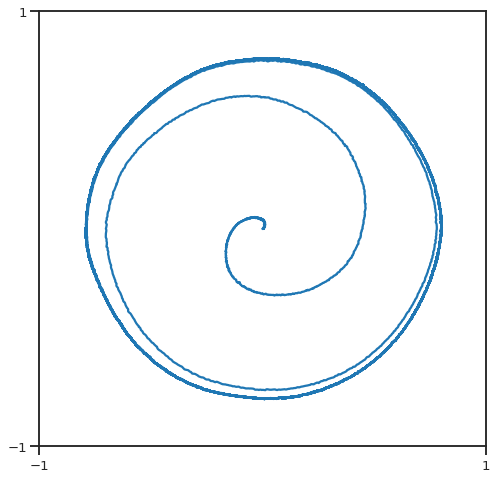

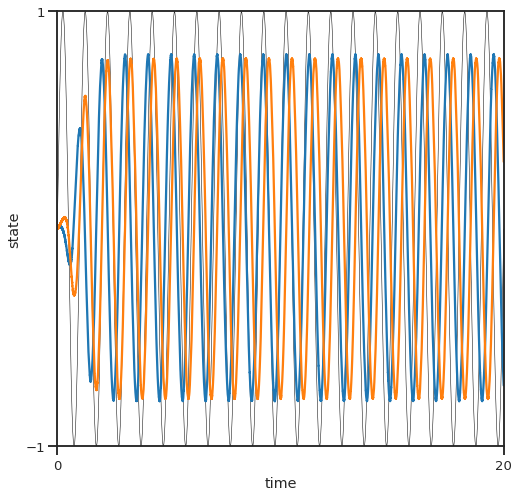

In [188]:
goNormal(100, Uniform(200, 400), Uniform(-1,1))

smaller rates

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

gain range: 0.1 to 11.3
bias range: -10.1 to 1.2
observed firing rate range: 0 to 39Hz


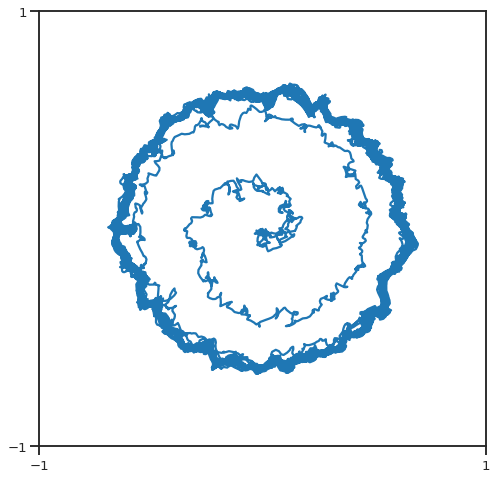

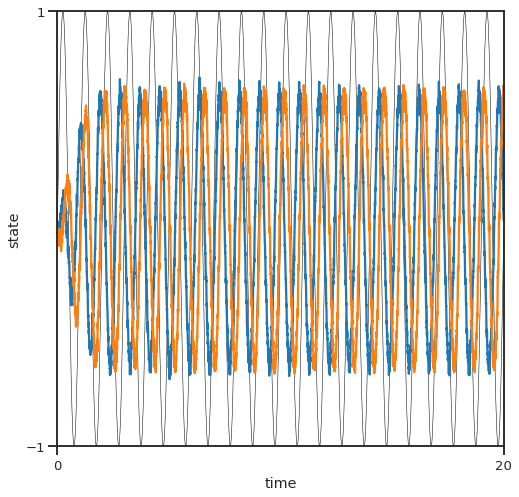

In [174]:
goNormal(100, Uniform(20, 40), Uniform(-1,1))

small intercept

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

gain range: 6.2 to 41.1
bias range: -2.1 to 4.3
observed firing rate range: 165 to 369Hz


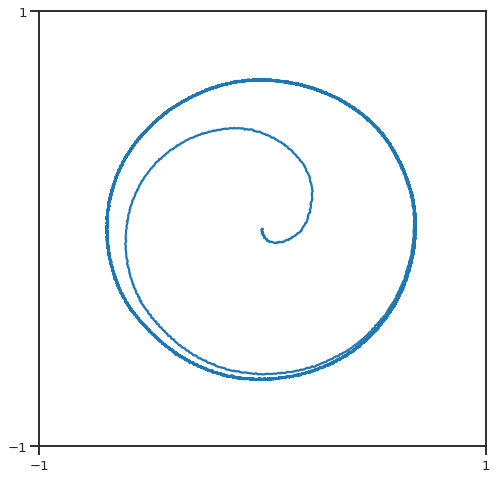

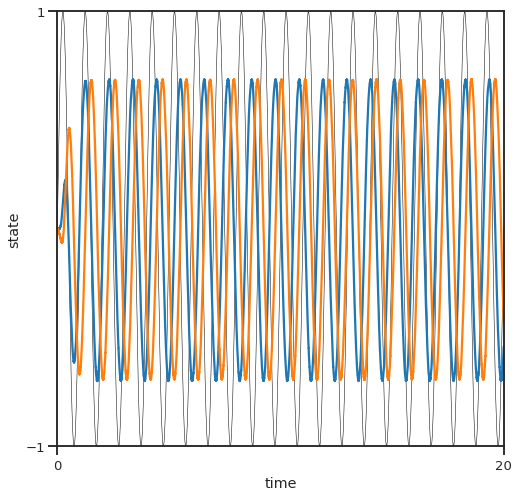

In [175]:
goNormal(100, Uniform(200, 400), Uniform(-0.1,0.1))

small rate and small intercept

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

gain range: 0.1 to 0.5
bias range: 1.0 to 1.0
observed firing rate range: 21 to 35Hz


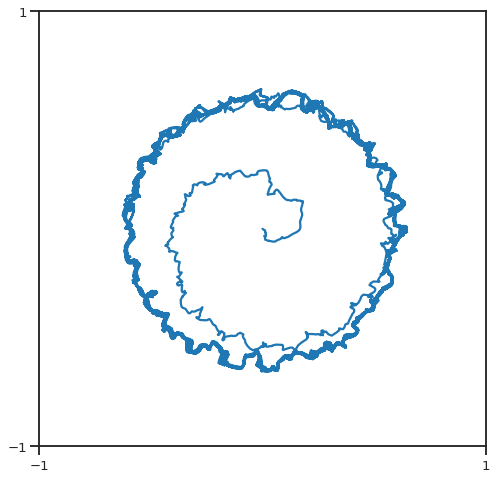

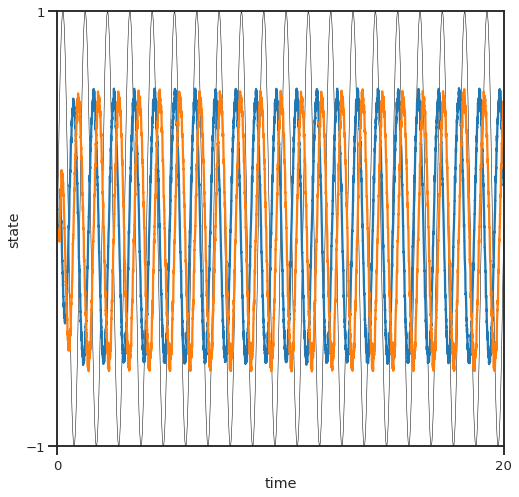

In [177]:
goNormal(100, Uniform(20, 40), Uniform(-0.1,0.1))

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

gain range: 0.1 to 3.6
bias range: -2.3 to 1.2
observed firing rate range: 0 to 39Hz


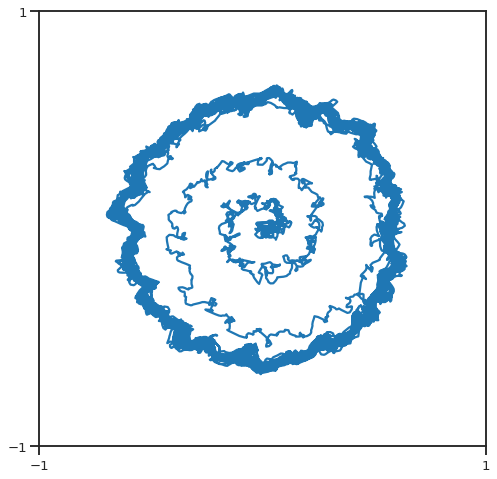

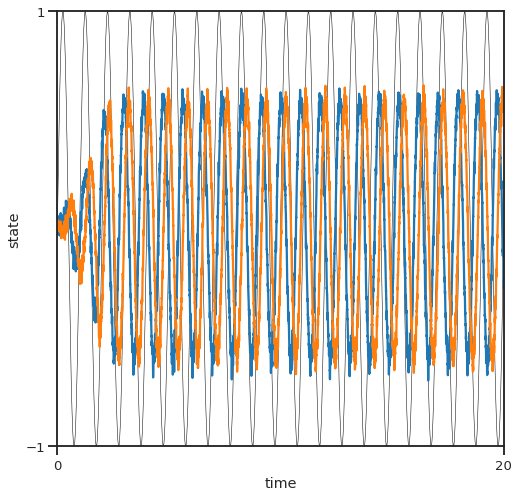

In [178]:
goNormal(100, Uniform(20, 40), Uniform(-0.9,0.9))

### The network can still do pretty well with low firing rates, even when the intercept is set such that biases are constrained to reasonable values

## Remove the bias current entirely

A helper function to calculate the gain necessary to achieve max_rate without a bias current
We just solve the LIFRate function to solve for the currents desired to have a maximum rate at $x=1$, given an intercept at $x=0$ (the natural intercept with zero bias)

In [179]:
def getGainLIF(nEns, max_rates):
    neuron = nengo.LIF()
    rates = np.array(max_rates.sample(nEns, rng=np.random.RandomState(seed=0)))
    ints = np.zeros_like(rates)
    bias = np.zeros_like(rates)
    # Solve LIFRate's step_math equation for the input current J required to achieve these rates
    J = 1.0 / (1 - np.exp((neuron.tau_ref - (1.0 / rates)) / neuron.tau_rc))
    # Now assume zero bias, and therefore zero intercept, then
    # compute the gains necessary to achieve these currents
    # J = gain * X + 0, where X is dot(x, e),
    # the dot product between the input vector and the neuron's encoder
    # the maximum firing rate occurs at X=1, so solve for gain
    gain = J
    # test in a small network
    with nengo.Network() as model:
        inpt = nengo.Node(lambda t: np.sin(t))
        # ens = nengo.Ensemble(nEns, 1, neuron_type=neuron, max_rates=rates, intercepts=ints)
        ens = nengo.Ensemble(nEns, 1, neuron_type=neuron, gain=gain, bias=bias)
        nengo.Connection(inpt, ens, synapse=None)
        pX = nengo.Probe(ens, synapse=0.1)
        pA = nengo.Probe(ens.neurons, synapse=0.1)
    with nengo.Simulator(model, progress_bar=False) as sim:
        sim.run(10, progress_bar=False)
    A = sim.data[pA]
    print(f'FEEDFORWARD: min-max observed firing rate: {np.min(np.max(A, axis=0)):.0f} - {np.max(A):.0f}Hz')
        
    return gain, bias

Main function

In [180]:
def goNoBias(
    n_neurons,
    max_rates, 
    tauRise=1e-3,
    tauFall=1e-1,
    tKick=0.1,
    tSim=20,
    seed=0,
    w=2*np.pi,
    tTrans=10,
    ):

    syn = DoubleExp(tauRise, tauFall)
    gain, bias = getGainLIF(n_neurons, max_rates)

    def feedback(x):
        r = np.maximum(np.sqrt(x[0]**2 + x[1]**2), 1e-9)
        dx0 = x[0]*(1-r**2)/r - x[1]*w 
        dx1 = x[1]*(1-r**2)/r + x[0]*w 
        return [tauFall*dx0 + x[0],  tauFall*dx1 + x[1]]

    model = nengo.Network()
    with model:
        stim = nengo.Node(lambda t: [1,0] if t<tKick else [0,0])
        osc = nengo.Ensemble(n_neurons, dimensions=2, seed=seed, gain=gain, bias=bias)
        nengo.Connection(stim, osc, synapse=syn)
        nengo.Connection(osc, osc, function=feedback, synapse=syn)
        osc_p = nengo.Probe(osc, synapse=syn)
        spikes_p = nengo.Probe(osc.neurons, synapse=syn)

    sim = nengo.Simulator(model)
    sim.run(tSim)
    A = sim.data[spikes_p]
    A_settled = A[int(tTrans/0.001):]

    fig, ax = plt.subplots(figsize=((8,8)))
    ax.plot(sim.data[osc_p][:,0],sim.data[osc_p][:,1])
    # ax.set(xlim=((-1,1)), ylim=((-1,1)), xticks=((-1,1)), yticks=((-1,1)))

    fig, ax = plt.subplots(figsize=((8,8)))
    ax.plot(sim.trange(), np.sin(w*sim.trange()), color='k', linewidth=0.5)
    ax.plot(sim.trange(), sim.data[osc_p])
    ax.set(xlabel='time', ylabel='state', ylim=((-1, 1)), yticks=((-1, 1)), xlim=((0, tSim)), xticks=((0, tSim)))
    
    print(f'FEEDBACK: min-max observed firing rate: {np.min(np.max(A_settled, axis=0)):.0f} - {np.max(A_settled):.0f}Hz')

High firing rates

FEEDFORWARD: min-max observed firing rate: 206 - 402Hz


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

FEEDBACK: min-max observed firing rate: 165 - 364Hz


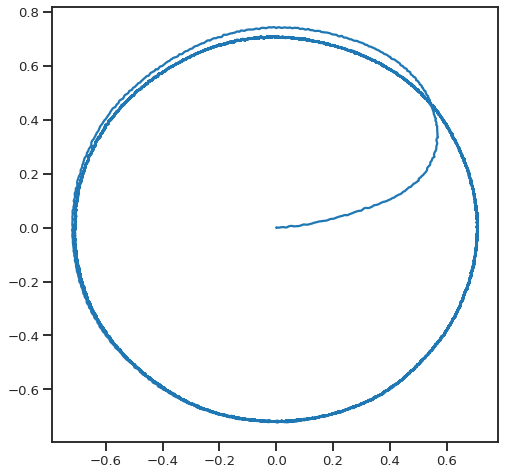

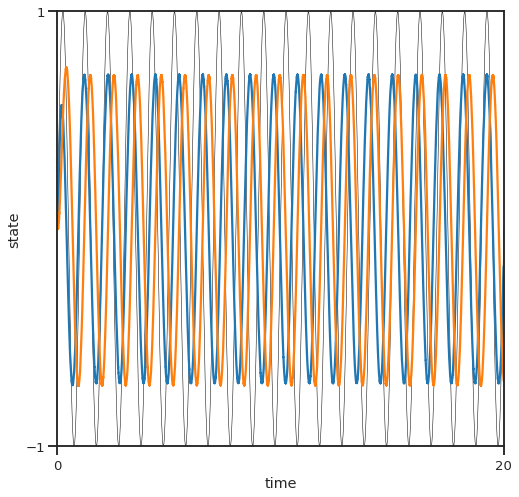

In [181]:
goNoBias(100, nengo.dists.Uniform(200, 400))

Looks good

Lower firing rates

FEEDFORWARD: min-max observed firing rate: 55 - 104Hz


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

FEEDBACK: min-max observed firing rate: 105 - 176Hz


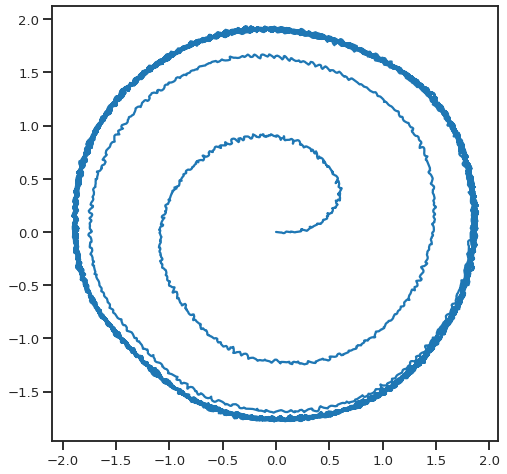

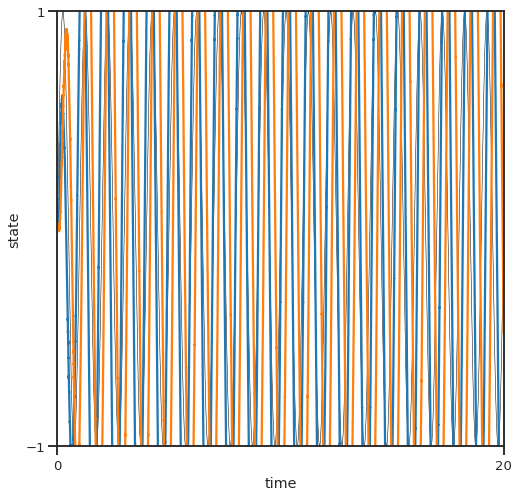

In [182]:
goNoBias(100, nengo.dists.Uniform(50, 100))

The attractor dynamics pulls the neurons out of their preferred firing rate regime to keep the system stable

Increase the number of neurons to compensate

FEEDFORWARD: min-max observed firing rate: 55 - 104Hz


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

FEEDBACK: min-max observed firing rate: 51 - 100Hz


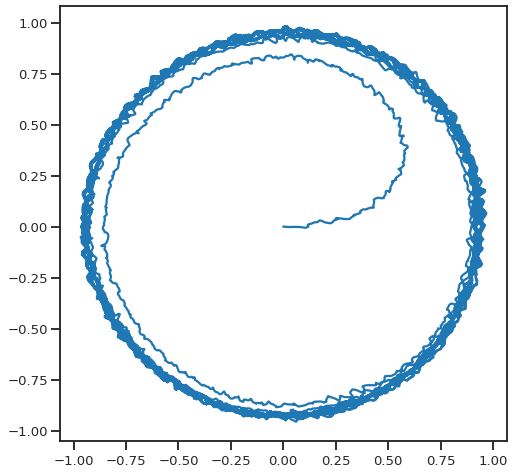

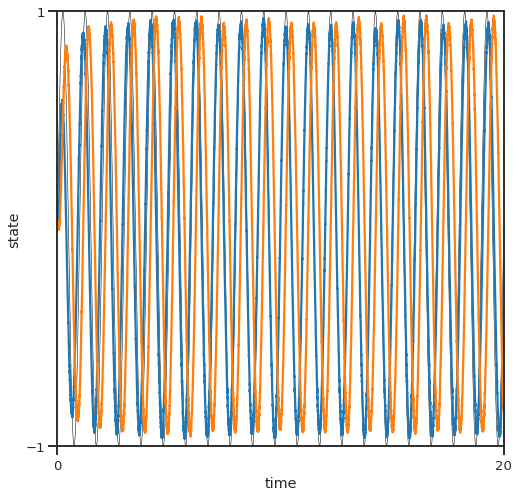

In [184]:
goNoBias(500, nengo.dists.Uniform(50, 100))

Lower firing rates

FEEDFORWARD: min-max observed firing rate: 35 - 65Hz


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

FEEDBACK: min-max observed firing rate: 29 - 62Hz


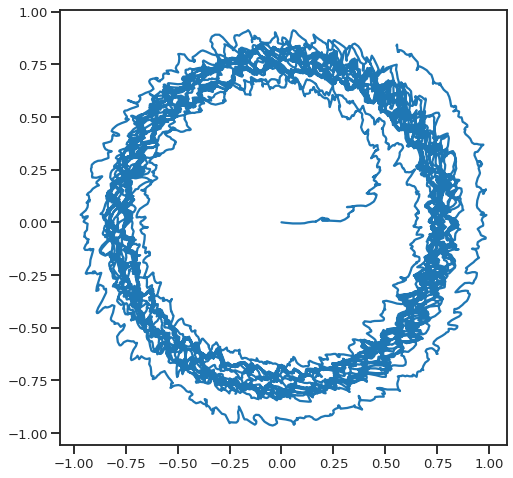

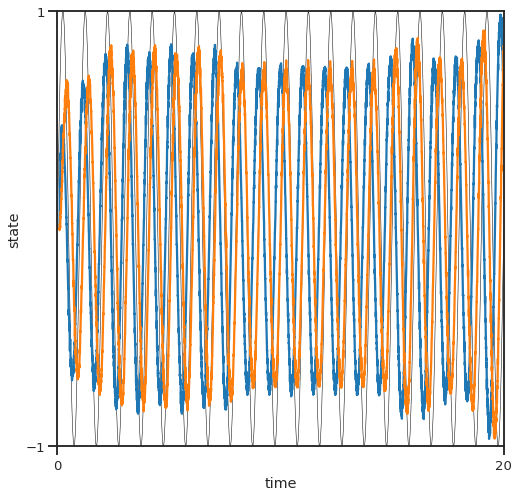

In [192]:
goNoBias(500, nengo.dists.Uniform(30, 60), tKick=0.1)

A little unstable, but still pretty good

FEEDFORWARD: min-max observed firing rate: 35 - 65Hz


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

FEEDBACK: min-max observed firing rate: 20 - 50Hz


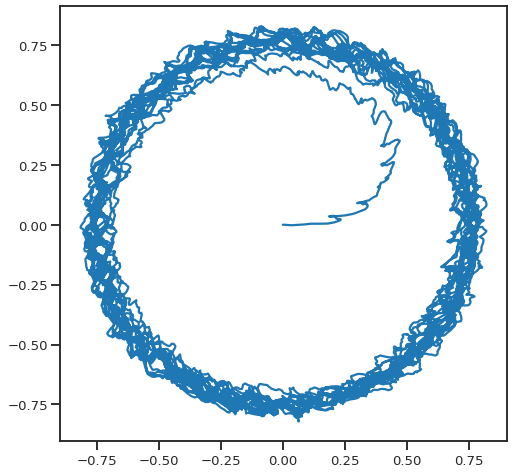

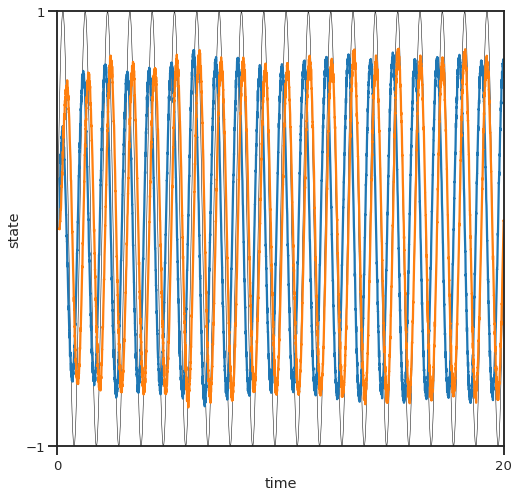

In [193]:
goNoBias(1000, nengo.dists.Uniform(30, 60), tKick=0.1)